# 03. Exploring the impact of cyclones on vegetation: use of geomedian and the relationship of NDVI change and cyclone windspeed

This notebook creates a geomedian image for the average landscape prior to a tropical cyclone. Furthermore a Landsat image is returned for the first scene directly after the event. NDVI is calculated for each scene and the difference of NDVI is then visualised. Finally, the notebook is used to import cyclone windfield data and examine the relationship between wind speed and NDVI change.

Cells titled "user requirement" indicate where users are required to edit code, the remaining code can be run normally. 

Code written in Janurary 2018 by Erin Telfer with support from Claire Krause. The notebook was completed as a graduate program project at Geoscience Australia. If you have comment or if you find an error, please contact erin.telfer@ga.gov.au. Alternatively, please contact Claire.Krause@ga.gov.au.

In [1]:
#Import libraries 

%pylab notebook
import pandas as pd
import xarray as xr
from datetime import date, timedelta
import gdal
from gdal import *

import datacube
from datacube.helpers import ga_pq_fuser
from datacube.storage import masking
from datacube.storage.masking import mask_to_dict
from datacube_stats.statistics import GeoMedian

from matplotlib.backends.backend_pdf import PdfPages
from matplotlib import pyplot as plt
import matplotlib.dates
from IPython.display import display
import ipywidgets as widgets

dc = datacube.Datacube(app='dc-show changes in annual mean NDVI values')

Populating the interactive namespace from numpy and matplotlib


# User requirement: specify directory locations

In [2]:
###User input: enter the directory location of input data. Ensure "/" are used, not "\"
input_folder = '/g/data/w85/ext547/input_data/'

###User input: enter the directory location of output data. Please enter again if the same as input_folder. Ensure "/" are used, not "\"
output_folder = '/g/data/w85/ext547/cyclone_repo/output_data/'

# User requirement: specifiy location of interest and details about cyclone

In [3]:
##User input: enter area of interest


# # #Conway Forest Debbie
lat_min = -20.440 #down
lat_max = -20.303 #up
lon_min = 148.692 #left
lon_max = 148.778 #right


# #TamOShanter National Park
# lat_min = -17.934 #down
# lat_max = -17.863 #up
# lon_min = 146.026 #left
# lon_max = 146.096 #right

# "Debbie sugar" 
# lat_min = -20.435 #down
# lat_max = -20.318 #up
# lon_min = 148.448 #left
# lon_max = 148.629 #right

# # "Large area", bananas, Larry 
# lat_min = -18.016 #down
# lat_max = -17.830 #up
# lon_min = 145.707 #left
# lon_max = 145.873 #right

# #Mission Beach Larry
# lat_min = -17.866 #down
# lat_max = -17.856 #up
# lon_min = 146.091 #left
# lon_max = 146.109 #right


# #'Mt Dryander QLD' Debbie
# lat_min = -20.267 #down
# lat_max = -20.216 #up
# lon_min = 148.534 #left
# lon_max = 148.592 #right

# # banana Debbie
# lat_min = -20.975 #down
# lat_max = -20.967 #up
# lon_min = 148.685 #left
# lon_max = 148.692 #right

#High Mt QLD Debbie
# lat_min = -20.375 #down
# lat_max = -20.340 #up
# lon_min = 148.757 #left
# lon_max = 148.806 #right

#Debbie
# lat_min = -20.385 #down
# lat_max = -20.326 #up
# lon_min = 148.916 #left
# lon_max = 148.984 #right

##User input: enter the name of vegetation of interest, e.g. "forest" or "banana crop"
vegetation_type = 'forest'

##User input: enter the name of the area/region/place/location of interest, e.g. "Hamilton Island"
location_name = 'Conway forest'

###User input: enter start and end date of cyclone
start_of_event= '2017-03-23'
end_of_event= '2017-04-07'

###User input: enter the name of cyclone
cyclone_name =  'Debbie'

###User input: set cloud threshold. This value defines the amount of lansdcape/cloud allowed in each scene. Scenes will not be retrieved that have less than the cloud threshold worth of image.
#The default value is "0.90" or >90% image and <10% cloud cover
cloud_free_threshold = 0.70 

# No more "user requirements" just run the remaining cells

While the remaining cells do not require any changes, the user can edit code as required

# Datacube query is completed

In [4]:
#Temporal range, wavelengths/band and sensors of interest are defined

#temporal range is defined
start_of_epoch = '2010-01-01'
end_of_epoch =  '2017-12-31'

#wavelengths/bands of interest are defined
bands_of_interest = [#'blue',
                     'green',
                     'red', 
                     'nir',
                     'swir1', 
                     #'swir2'
                     ]

#Landsat sensors of interest are defined
sensors = ['ls8',
       'ls7',
      'ls5'] 

#query is created
query = {'time': (start_of_epoch, end_of_epoch),}
query['x'] = (lon_min, lon_max)
query['y'] = (lat_max, lat_min)
query['crs'] = 'EPSG:4326'

In [5]:
#Reformat variables

start_of_event=datetime.datetime.strptime(start_of_event,'%Y-%m-%d') #Convert to datetime
end_of_event=datetime.datetime.strptime(end_of_event,'%Y-%m-%d') #Convert to datetime
location_name=location_name.replace(" ","_") #replace spaces with underscore

# Extract data from Open Datacube

The extracted data is first filtered using the criteria in "mask_components". 
The cloudiness of the scenes is then tested, and any scenes that do not meet the given "cloud_free_threshold" are discarded.
Additionally, any pixel that is located within the ocean/sea will be converted to "nan" values with the 'land_sea' command.

In [6]:
#Create cloud mask. This will define which pixel quality (PQ) artefacts are removed from the results. It should be noted the "land_sea" code will remove all ocean/sea pixels.

mask_components = {'cloud_acca':'no_cloud',
'cloud_shadow_acca' :'no_cloud_shadow',
'cloud_shadow_fmask' : 'no_cloud_shadow',
'cloud_fmask' :'no_cloud',
'blue_saturated' : False,
'green_saturated' : False,
'red_saturated' : False,
'nir_saturated' : False,
'swir1_saturated' : False,
'swir2_saturated' : False,
'contiguous':True,
'land_sea':'land'}

In [7]:
#Retrieve the data for each Landsat sensor

sensor_clean = {}

for sensor in sensors:
    #load the NBAR and corresponding PQ
    sensor_nbar = dc.load(product= sensor+'_nbar_albers', group_by='solar_day', 
                          measurements = bands_of_interest,  **query)
    sensor_pq = dc.load(product= sensor+'_pq_albers', group_by='solar_day', 
                        fuse_func=ga_pq_fuser, **query)
    
    #retrieve the projection information before masking/sorting
    crs = sensor_nbar.crs
    crswkt = sensor_nbar.crs.wkt
    affine = sensor_nbar.affine
    
    #ensure there's PQ to go with the NBAR
    sensor_nbar = sensor_nbar.sel(time = sensor_pq.time)
    
    #apply the PQ masks to the NBAR
    quality_mask = masking.make_mask(sensor_pq, **mask_components)
    good_data = quality_mask.pixelquality.loc[start_of_epoch:end_of_epoch]
    sensor_nbar2 = sensor_nbar.where(good_data)
    
    #calculate the percentage cloud free for each scene
    cloud_free = masking.make_mask(sensor_pq, cloud_acca='no_cloud', cloud_fmask='no_cloud', 
                                   contiguous=True).pixelquality
    mostly_cloud_free = cloud_free.mean(dim=('x','y')) >= cloud_free_threshold
        
    #discard data that does not meet the cloud_free_threshold
    mostly_good = sensor_nbar2.where(mostly_cloud_free).dropna(dim='time', how='all')
    mostly_good['product'] = ('time', numpy.repeat(sensor, mostly_good.time.size))    
    sensor_clean[sensor] = mostly_good

    print('loaded %s' % sensor) 
    

print ('complete')

loaded ls8
loaded ls7
loaded ls5
complete


In [8]:
#Check the output

sensor_clean

{'ls5': <xarray.Dataset>
 Dimensions:  (time: 7, x: 434, y: 653)
 Coordinates:
   * time     (time) datetime64[ns] 2010-10-24T23:54:42.500000 ...
   * y        (y) float64 -2.291e+06 -2.291e+06 -2.291e+06 -2.291e+06 ...
   * x        (x) float64 1.727e+06 1.727e+06 1.728e+06 1.728e+06 1.728e+06 ...
 Data variables:
     green    (time, y, x) float64 730.0 761.0 698.0 761.0 887.0 982.0 887.0 ...
     red      (time, y, x) float64 590.0 590.0 615.0 689.0 788.0 912.0 838.0 ...
     nir      (time, y, x) float64 3.338e+03 3.208e+03 3.078e+03 3.046e+03 ...
     swir1    (time, y, x) float64 2.31e+03 2.31e+03 2.157e+03 2.157e+03 ...
     product  (time) <U3 'ls5' 'ls5' 'ls5' 'ls5' 'ls5' 'ls5' 'ls5'
 Attributes:
     crs:      EPSG:3577, 'ls7': <xarray.Dataset>
 Dimensions:  (time: 51, x: 434, y: 653)
 Coordinates:
   * time     (time) datetime64[ns] 2010-01-17T23:56:23.500000 ...
   * y        (y) float64 -2.291e+06 -2.291e+06 -2.291e+06 -2.291e+06 ...
   * x        (x) float64 1.727e+06 1.7

In [9]:
#Concatenate (join) data from different sensors together and sort so that observations are sorted by time rather than sensor

nbar_clean = xr.concat(sensor_clean.values(), 'time')
nbar_clean = nbar_clean.sortby('time')
nbar_clean.attrs['crs'] = crs
nbar_clean.attrs['affin|e'] = affine

In [10]:
#Check that the concatenation worked

nbar_clean

<xarray.Dataset>
Dimensions:  (time: 91, x: 434, y: 653)
Coordinates:
  * y        (y) float64 -2.291e+06 -2.291e+06 -2.291e+06 -2.291e+06 ...
  * x        (x) float64 1.727e+06 1.727e+06 1.728e+06 1.728e+06 1.728e+06 ...
  * time     (time) datetime64[ns] 2010-01-17T23:56:23.500000 ...
Data variables:
    green    (time, y, x) float64 nan nan nan nan nan nan nan nan nan nan ...
    red      (time, y, x) float64 nan nan nan nan nan nan nan nan nan nan ...
    nir      (time, y, x) float64 nan nan nan nan nan nan nan nan nan nan ...
    swir1    (time, y, x) float64 nan nan nan nan nan nan nan nan nan nan ...
    product  (time) <U3 'ls7' 'ls7' 'ls7' 'ls7' 'ls7' 'ls5' 'ls7' 'ls7' ...
Attributes:
    crs:      EPSG:3577
    affin|e:  | 25.00, 0.00, 1727450.00|\n| 0.00,-25.00,-2290925.00|\n| 0.00,...

# Calculate geomedian for all scenes prior to cyclone

In [11]:
#remove product data variable from array to enable GeoMedian code
nbar_clean=nbar_clean.drop('product')

#select all scenes that occur before the start of the cyclone
nbar_gm= nbar_clean.sel(time=slice(start_of_epoch, start_of_event))

#geomedian transform
nbar_gm=GeoMedian().compute(nbar_gm)

# Plot imagery and NDVI for the geomedian of all data prior to the cyclone

In [12]:
#Prepare geomedian imagery

rgb = nbar_gm.to_array(dim='color').sel(color=[
    'swir1','nir', 'green']).transpose('y', 'x', 'color')
fake_saturation = 6000.0
rgb = rgb.astype('double')
clipped_visible = rgb.where(rgb<fake_saturation).fillna(fake_saturation)
max_val = clipped_visible.max(['y', 'x'])
scaled = (clipped_visible / max_val)

<IPython.core.display.Javascript object>


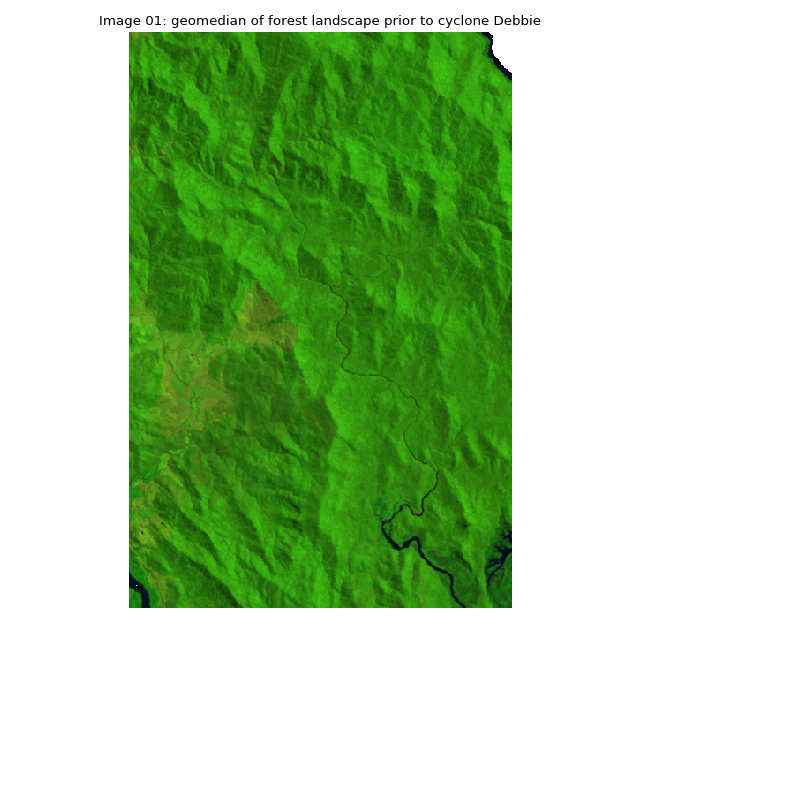

In [39]:
#Create image that shows the geomedian of the landscape from all scenes prior to cyclone

fig = plt.figure(figsize =(8,8)) #edit size of plot 
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05) #set border dimensions
fig.patch.set_facecolor('white') #make border white 
fig.patch.set_alpha(0.99)#ensure border white
plt.axis('off')#remove axis 
plt.title('Image 01: geomedian of ' + str(vegetation_type)+ ' landscape prior to cyclone '+ str(cyclone_name)) #add title
plt.imshow(scaled, interpolation = 'nearest') #create image

In [40]:
#Save figure
plt.savefig(str(output_folder)+'NB03_1_geomedian_image01_'+str(cyclone_name)+'_'+str(location_name))

In [41]:
#Calculate NDVI
ndvi = ((nbar_gm.nir-nbar_gm.red)/(nbar_gm.nir+nbar_gm.red))
ndvi = ndvi.where(ndvi>=0.0)

ndvi.attrs['crs'] = crs
ndvi.attrs['affine'] = affine

<IPython.core.display.Javascript object>


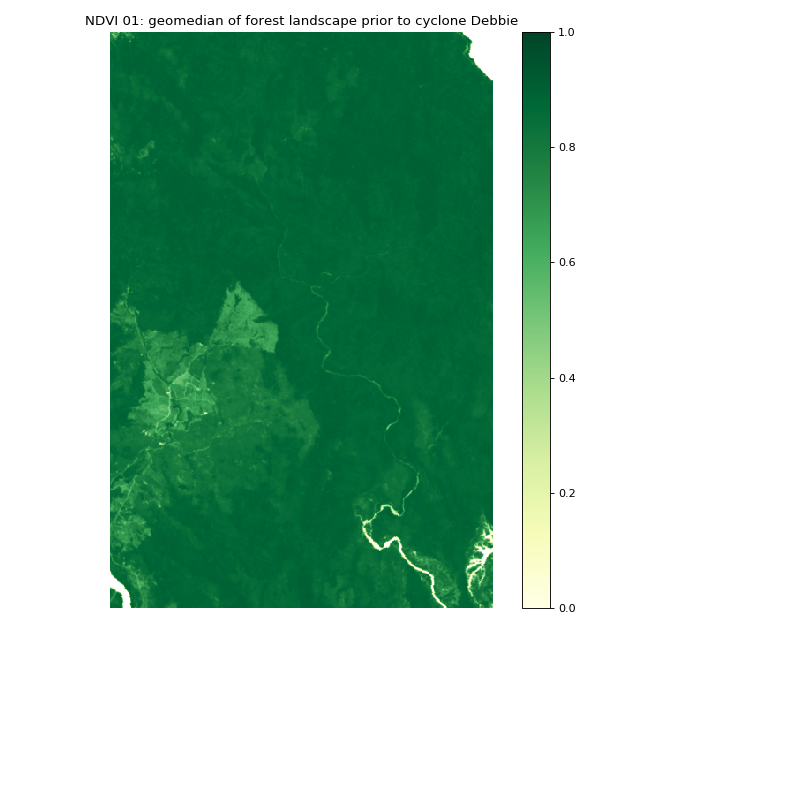

(-0.5, 433.5, 652.5, -0.5)

In [42]:
#Plot NDVI for geomedian of landscape prior to the cyclone
#create plot
fig = plt.figure(figsize =(8,8)) #edit size of plot
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05) #set border dimensions
fig.patch.set_facecolor('white') #make border white 
fig.patch.set_alpha(0.99)#ensure border white
i=plt.imshow(ndvi,interpolation = 'nearest', cmap = 'YlGn', vmin=0,vmax=1) #create image with colourbar
fig.colorbar(i) #add colourbar
plt.title('NDVI 01: geomedian of ' + str(vegetation_type)+ ' landscape prior to cyclone '+ str(cyclone_name)) #add title
plt.axis('off')#remove axis

In [43]:
#Save figure
plt.savefig(str(output_folder)+'NB03_3_geomedian_NDVI01_'+str(cyclone_name)+'_'+str(location_name))

# Landscape and NDVI of scene after cyclone

In [44]:
#Prepare imagery for scene after cyclone

rgb02 = nbar_clean.sel(time =end_of_event, method = 'backfill').to_array(dim='color').sel(color=[
    'swir1','nir', 'green']).transpose('y', 'x', 'color')
fake_saturation = 6000.0
rgb02 = rgb02.astype('double')
clipped_visible02 = rgb02.where(rgb02<fake_saturation).fillna(fake_saturation)
max_val02 = clipped_visible02.max(['y', 'x'])
scaled02 = (clipped_visible02 / max_val02)

<IPython.core.display.Javascript object>


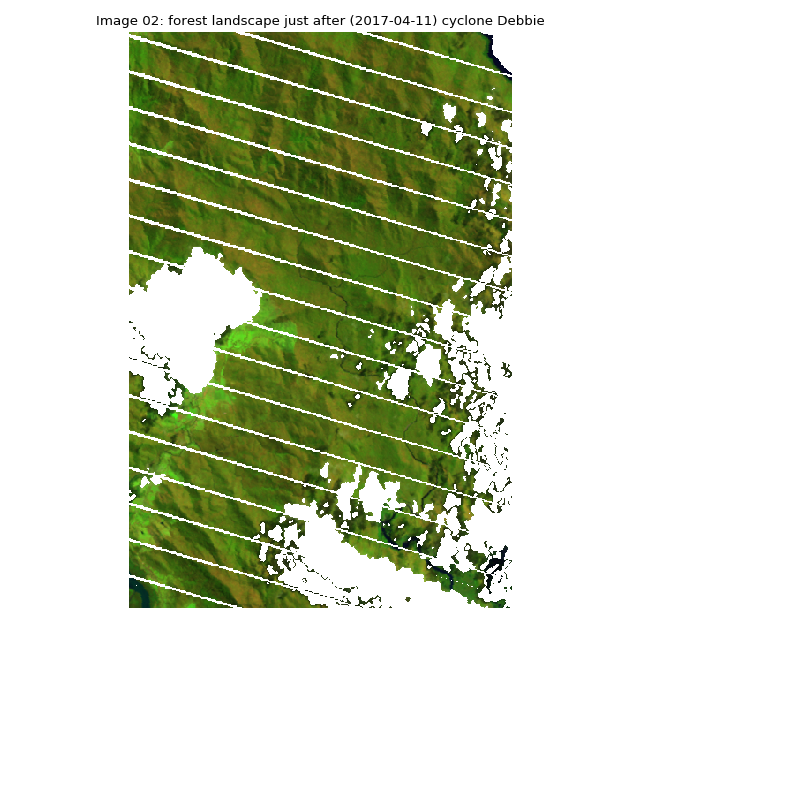

In [45]:
#Create image that shows landscape after cyclone

fig = plt.figure(figsize =(8,8)) #edit size of plot
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05) #set border dimensions
fig.patch.set_facecolor('white') #make border white
fig.patch.set_alpha(0.99)#ensure border white
plt.axis('off')#remove axis
plt.title('Image 02: ' + str(vegetation_type)+ ' landscape just after ('+str(scaled02.time.values)[0:10]+') cyclone '+ str(cyclone_name))#add title
plt.imshow(scaled02, interpolation = 'nearest') #create image
plt.show() #show image

In [46]:
#Save figure
plt.savefig(str(output_folder)+'NB03_2_landscape_image02_'+str(cyclone_name)+'_'+str(location_name)+'_'+str(scaled02.time.values)[0:10])

In [47]:
#Calculate NDVI and select for scene after cyclone
ndvi_after_event = ((nbar_clean.nir-nbar_clean.red)/(nbar_clean.nir+nbar_clean.red))
ndvi_of_interest02= ndvi_after_event.sel(time = end_of_event, method='backfill')

<IPython.core.display.Javascript object>


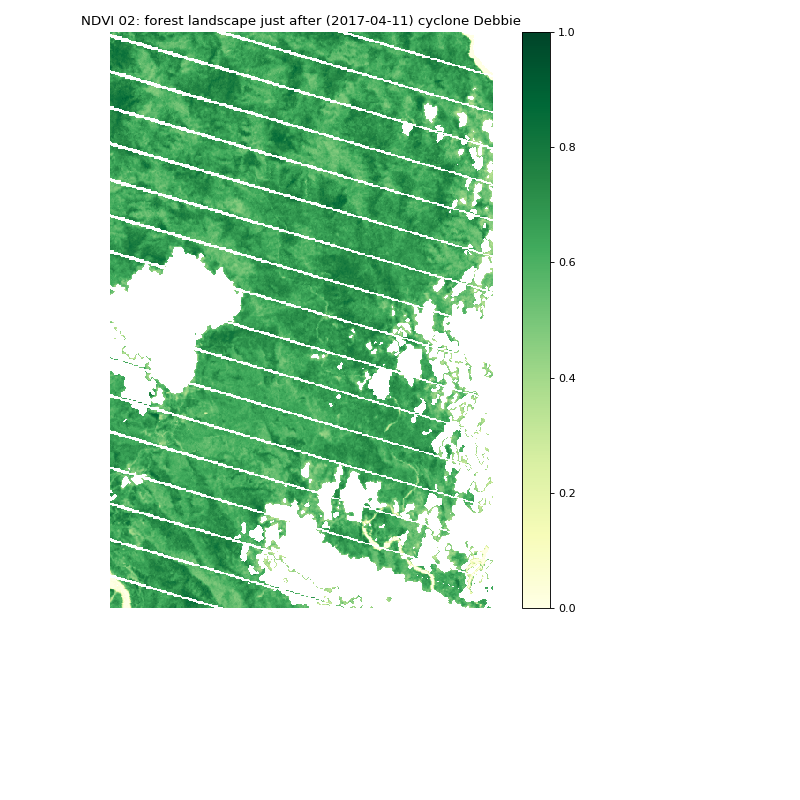

Text(0.5,1,'NDVI 02: forest landscape just after (2017-04-11) cyclone Debbie')

In [48]:
#Plot NDVI for scene after cyclone
fig = plt.figure(figsize =(8,8)) #edit size of plot
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05) #set border dimensions
fig.patch.set_facecolor('white') #make border white 
fig.patch.set_alpha(0.99)#ensure border white
plt.axis('off')#remove axis
i=plt.imshow(ndvi_of_interest02,interpolation = 'nearest', cmap = 'YlGn', vmin=0,vmax=1) #create image with colourbar
fig.colorbar(i) #add colourbar
plt.title('NDVI 02: ' + str(vegetation_type)+ ' landscape just after ('+str(scaled02.time.values)[0:10]+') cyclone '+ str(cyclone_name)) #add title

In [49]:
#Save figure
plt.savefig(str(output_folder)+'NB03_4_NDVI02_'+str(cyclone_name)+'_'+str(location_name)+'_'+str(scaled02.time.values)[0:10])

# The difference in vegetation between the geomedian and the scene after cyclone

In [50]:
#Calculate the difference in NDVI from between geomedian and after the cyclone
ndvi_change= ndvi_of_interest02-ndvi
ndvi_change.attrs['affine'] = affine

In [51]:
#Calculate the average difference in NDVI
ndvi_mean_change =ndvi_change.mean(dim=('x','y'))
percentage_ndvi_mean_change= (ndvi_mean_change /(ndvi.mean(dim=('x','y'))))*100
print('Average difference in NDVI: ' +str(ndvi_mean_change.values)[0:5])
print('percentage change of NDVI: ' +str((percentage_ndvi_mean_change.values))[0:5]+'%')

Average difference in NDVI: -0.21
percentage change of NDVI: -25.3%


<IPython.core.display.Javascript object>


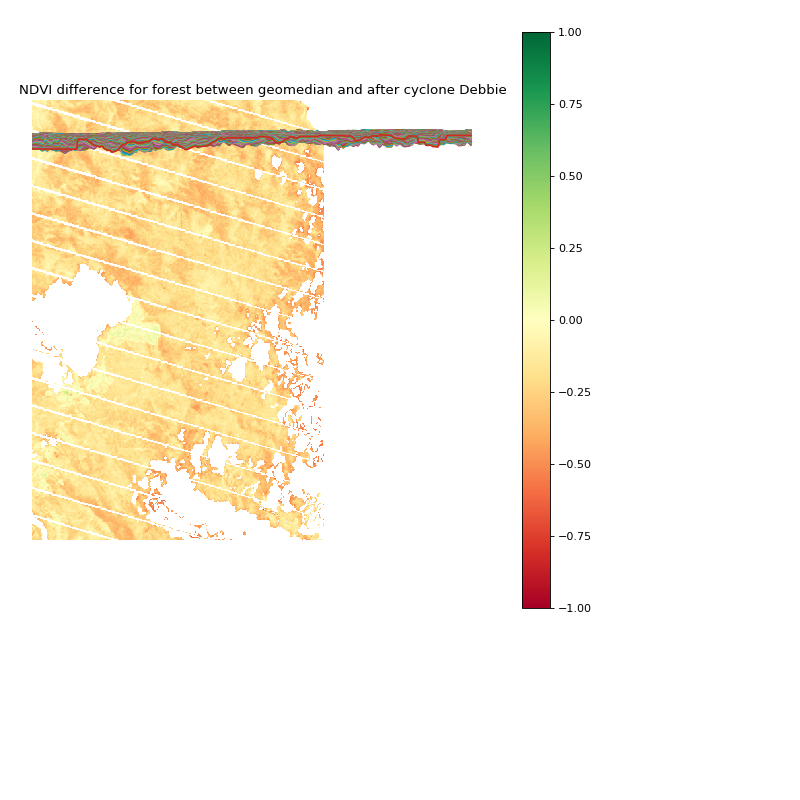

In [52]:
#Plot the change of NDVI
fig = plt.figure(figsize =(8,8)) #edit size of plot
i=plt.imshow(ndvi_change,interpolation = 'nearest', cmap = 'RdYlGn', vmin=-1,vmax=1) #create image with colourbar
fig.colorbar(i) #add colourbar
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05) #set border dimensions
fig.patch.set_facecolor('white') #make border white 
fig.patch.set_alpha(0.99)#ensure border white
plt.title('NDVI difference for '+str(vegetation_type)+ ' between geomedian and after cyclone '+str(cyclone_name)) #add title
plt.axis('off')#remove axis
plt.show() #show image

In [53]:
#Save figure
plt.savefig(str(output_folder)+'NB03_5_NDVI_geomedian_change_'+str(cyclone_name)+'_'+str(location_name))

# Import and process windfield data to ensure pixel size and projection is the same as NDVI dataset

In [54]:
#read windfield geotiff
windfield = gdal.Open(input_folder+'Final_corrected_TCDebbie_wind.tif', gdal.GA_ReadOnly)
windfield

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7f542d617930> >

In [55]:
#get projection information from windfiled
windfield_proj = windfield.GetProjection()
windfield_proj

'GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]]'

In [56]:
#Convert NDVI data array to raster saved in memory

#save NDVI_change dataset to a numpy array
ndvi_array = np.asarray(ndvi_change)

#define conversion variables
cols= int(ndvi_change.x.count())
rows= int(ndvi_change.y.count())
originX= ndvi_change.affine.c
dx= ndvi_change.affine.a
originY= ndvi_change.affine.f
dy= ndvi_change.affine.e
epsg=int((str(crs)).replace('EPSG:',''))
nodata=0

#complete conversion of NDVI array into raster
driver = gdal.GetDriverByName('MEM')
ndvi_raster = driver.Create('ndvi', cols, rows, 1, gdal.GDT_Float32)
ndvi_raster.SetGeoTransform((originX, dx, 0, originY, 0, dy))
ndvi_band = ndvi_raster.GetRasterBand(1)
ndvi_band.WriteArray(ndvi_array)
ndvi_band.SetNoDataValue(nodata)
ndvi_raster_SRS = osr.SpatialReference()
ndvi_raster_SRS.ImportFromEPSG(epsg)
ndvi_raster.SetProjection(ndvi_raster_SRS.ExportToWkt())
ndvi_band.FlushCache()

In [57]:
#Save metadata from NDVI_change
match_ds = ndvi_raster
match_proj = match_ds.GetProjection()
match_geotrans = match_ds.GetGeoTransform()
wide = match_ds.RasterXSize
high = match_ds.RasterYSize

In [58]:
#Create a  geotiff that is the same size and is in the same projection as the NDVI dataset
drv = gdal.GetDriverByName('GTiff')
windfield_matched = drv.Create('ouput_file', wide, high, 1, gdal.GDT_Float32)
windfield_matched.SetGeoTransform(match_geotrans)
windfield_matched.SetProjection(match_proj)

#create windfield geotiff
resampling_method = gdalconst.GRA_Bilinear
gdal.ReprojectImage(windfield, windfield_matched, windfield_proj, match_proj, resampling_method)

#view datasets and projections to ensure information looks correct
print ('windfield       = ', windfield)
print ('windfield_matched             = ',windfield_matched)
print ('windfield_proj        = ',windfield_proj)
print ('match_proj      = ',match_proj)

windfield       =  <osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7f542d617930> >
windfield_matched             =  <osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7f542d7de960> >
windfield_proj        =  GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]]
match_proj      =  PROJCS["GDA94 / Australian Albers",GEOGCS["GDA94",DATUM["Geocentric_Datum_of_Australia_1994",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],TOWGS84[0,0,0,0,0,0,0],AUTHORITY["EPSG","6283"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4283"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["standard_parallel_1",-18],PARAMETER["standard_parallel_2",-36],PARAMETER["latitude_of_center",0],PARAMETER["longitude_

# Save resampled windfield as an array and check array shape¶

In [59]:
windfield_matched_array=windfield_matched.ReadAsArray()

#check that arrays have the same shape
print('windfield shape = '+ str(shape(windfield_matched_array)))
print('ndvi_change shape = '+ str(shape(ndvi_change.values)))

windfield shape = (653, 434)
ndvi_change shape = (653, 434)


# Create a plot that examines relationship between wind and change in NDVI after a cyclone

In [60]:
#set variables to allow automatic X-axis on plot
x_min=np.around(np.amin(windfield_matched_array),decimals=-1)-10
x_max=np.around(np.amax(windfield_matched_array),decimals=-1)+10
x_num= np.around(np.amax(windfield_matched_array)-np.amin(windfield_matched_array))

In [61]:
plt.plot(windfield_matched_array)
plt.show()

In [62]:
#Create an xarray array of NDVI change and windfield data
coords_da={'y': ndvi_change.y, 'x': ndvi_change.x} #create coordinate variable
windfield_da = xr.DataArray(windfield_matched_array, dims=('y','x'), coords=coords_da) #create windfield dataset in correct format
relationship_ds = xr.Dataset({'ndvi_dataset': ndvi_change, 'windfield_dataset': windfield_da}) #create xarray

relationship_xr=relationship_ds.groupby_bins(relationship_ds.windfield_dataset,bins=x_num,include_lowest=True) #groupby bins in order to understand trend
mean_relationship=relationship_xr.mean() #take mean of each bin

mean_relationship

<xarray.Dataset>
Dimensions:                 (windfield_dataset_bins: 38)
Coordinates:
  * windfield_dataset_bins  (windfield_dataset_bins) object (43.177, 44.208] ...
Data variables:
    ndvi_dataset            (windfield_dataset_bins) float64 -0.1182 -0.1572 ...
    windfield_dataset       (windfield_dataset_bins) float64 43.69 44.86 ...

<IPython.core.display.Javascript object>


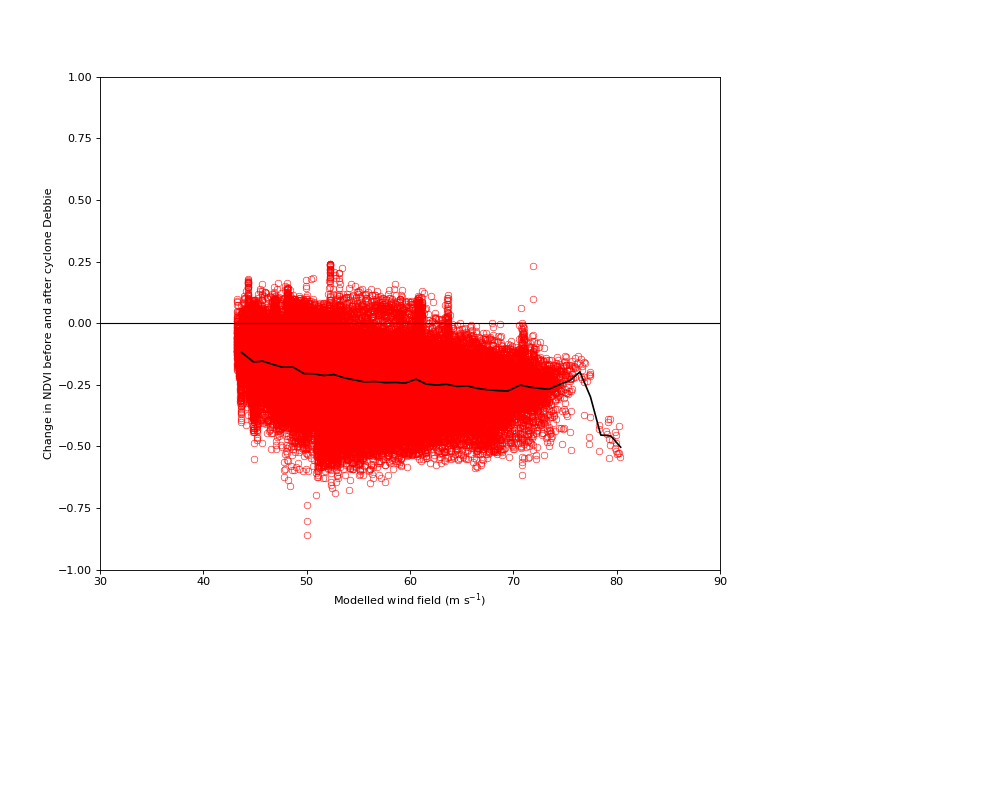

In [63]:
#create plot that compares change in NDVI and windfield values
fig = plt.figure(figsize=(10,8))
plt.plot(windfield_matched_array, ndvi_change.values, 'o', markeredgecolor='red', markeredgewidth=0.5, markerfacecolor='None') 
plot(mean_relationship.windfield_dataset,mean_relationship.ndvi_dataset, 'k')

plt.axis([x_min , x_max ,-1.0, 1.0], 'tight')
plt.xlabel('Modelled wind field (m s$^{-1}$)') #Set X label
plt.ylabel('Change in NDVI before and after cyclone '+str(cyclone_name)) #Set Y label
plt.plot([x_min, x_max], [0,0], 'k-', lw=1) #add blackline at 0 to plot
fig.patch.set_facecolor('white') #Make background white
fig.patch.set_alpha(0.99)#Make border white

In [64]:
#Save figure
plt.savefig(str(output_folder)+'NB03_6_windfield_vs_NDVIchange'+str(cyclone_name)+'_'+str(location_name))